In [866]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

DataSet utilizado "Porter Delivery Time Estimation Dataset" - https://www.kaggle.com/datasets/ranitsarkar01/porter-delivery-time-estimation   

Empresa fictícia: Porter Logistics.  

Objetivo: construir um modelo simples e interpretável para estimar o tempo total de entrega a partir dos dados fornecidos.


In [867]:
porter_df = pd.read_csv('PorterDeliveryTimeEstimationDataset.csv')

# Removendo linhas com valores ausentes em colunas com pouco menos de 1% de dados faltantes
porter_df = porter_df.dropna(subset=["actual_delivery_time", "market_id", "order_protocol"])

# Convertendo "actual_delivery_time" e "created_at" para datetime e calculando "delivery_time" em minutos
porter_df["actual_delivery_time"] = pd.to_datetime(porter_df["actual_delivery_time"])
porter_df["created_at"] = pd.to_datetime(porter_df["created_at"])

porter_df["delivery_time"] = (porter_df["actual_delivery_time"] - porter_df["created_at"]).dt.total_seconds() / 60  # Convertendo para minutos

porter_df = porter_df.drop(columns=["actual_delivery_time"])

In [ ]:
# Separando "created_at" em componentes de dia da semana, hora e se é fim de semana
porter_df["created_at_dayofweek"] = porter_df["created_at"].dt.dayofweek
porter_df["created_at_hour"] = porter_df["created_at"].dt.hour

# Convertendo colunas de dow e hora para utilizar seno e cosseno com o âmbito de capturar a natureza cíclica desses dados
porter_df["dayofweek_sin"] = np.sin(2 * np.pi * porter_df["created_at_dayofweek"] / 7)
porter_df["dayofweek_cos"] = np.cos(2 * np.pi * porter_df["created_at_dayofweek"] / 7)
porter_df["hour_sin"] = np.sin(2 * np.pi * porter_df["created_at_hour"] / 24)
porter_df["hour_cos"] = np.cos(2 * np.pi * porter_df["created_at_hour"] / 24)

# Removendo colunas originais
porter_df = porter_df.drop(columns=["created_at_dayofweek", "created_at_hour"])
porter_df = porter_df.drop(columns=["created_at"])

In [869]:
print(porter_df.select_dtypes(include=["str", "category"]).nunique().sort_values(ascending=False))

# Removendo colunas com alta cardinalidade
porter_df = porter_df.drop(columns=["store_id"])

store_id                  6740
store_primary_category      74
dtype: int64


In [870]:
# Preencher nulos de store_primary_category com "missing" e aplica One-Hot Encoding
porter_df["store_primary_category"] = porter_df["store_primary_category"].fillna("missing")
porter_df = pd.get_dummies(porter_df, columns=["market_id", "order_protocol", "store_primary_category"], drop_first=False)

In [871]:
# Fazendo o split dos dados em treino e teste
porter_df_x = porter_df.drop(columns=["delivery_time"])
porter_df_y = porter_df["delivery_time"]

train_x, test_x, train_y, test_y = train_test_split(porter_df_x, porter_df_y, test_size=0.2, random_state=42)

In [872]:
# preenchendo valores ausentes com a mediana
TOP_median = train_x["total_onshift_partners"].median()
TBP_median = train_x["total_busy_partners"].median()
TOO_median = train_x["total_outstanding_orders"].median()

train_x["total_onshift_partners"] = train_x["total_onshift_partners"].fillna(TOP_median)
train_x["total_busy_partners"] = train_x["total_busy_partners"].fillna(TBP_median)
train_x["total_outstanding_orders"] = train_x["total_outstanding_orders"].fillna(TOO_median)
test_x["total_onshift_partners"] = test_x["total_onshift_partners"].fillna(TOP_median)
test_x["total_busy_partners"] = test_x["total_busy_partners"].fillna(TBP_median)
test_x["total_outstanding_orders"] = test_x["total_outstanding_orders"].fillna(TOO_median)

# Criando coluna de "available_partners" como a diferença entre "total_onshift_partners" e "total_busy_partners" limitada a um mínimo de 0
train_x["available_partners"] = (train_x["total_onshift_partners"] - train_x["total_busy_partners"]).clip(lower=0)
test_x["available_partners"] = (test_x["total_onshift_partners"] - test_x["total_busy_partners"]).clip(lower=0)
train_x = train_x.drop(columns=["total_onshift_partners", "total_busy_partners"])
test_x = test_x.drop(columns=["total_onshift_partners", "total_busy_partners"])

train_x.shape, test_x.shape, train_y.shape, test_y.shape

((156740, 99), (39186, 99), (156740,), (39186,))

In [873]:
train_x.info()

<class 'pandas.DataFrame'>
Index: 156740 entries, 152283 to 122905
Data columns (total 99 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   total_items                               156740 non-null  int64  
 1   subtotal                                  156740 non-null  int64  
 2   num_distinct_items                        156740 non-null  int64  
 3   min_item_price                            156740 non-null  int64  
 4   max_item_price                            156740 non-null  int64  
 5   total_outstanding_orders                  156740 non-null  float64
 6   dayofweek_sin                             156740 non-null  float64
 7   dayofweek_cos                             156740 non-null  float64
 8   hour_sin                                  156740 non-null  float64
 9   hour_cos                                  156740 non-null  float64
 10  market_id_1.0                  

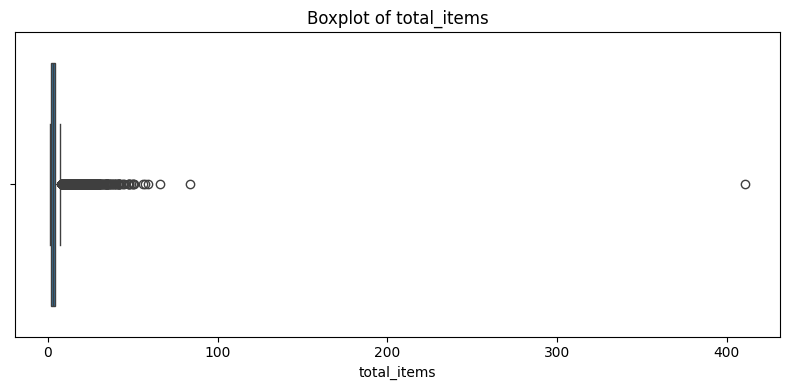

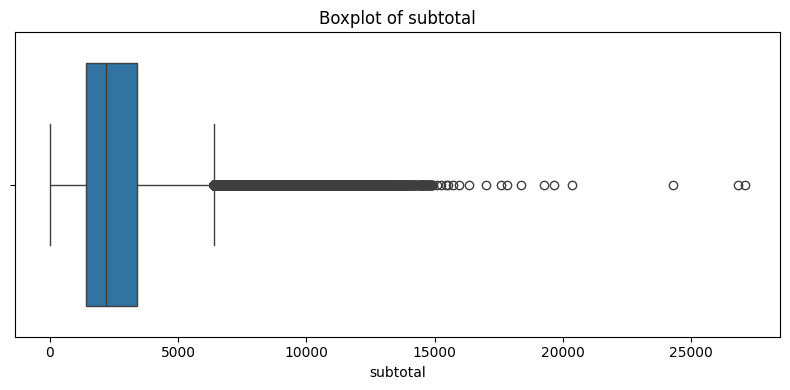

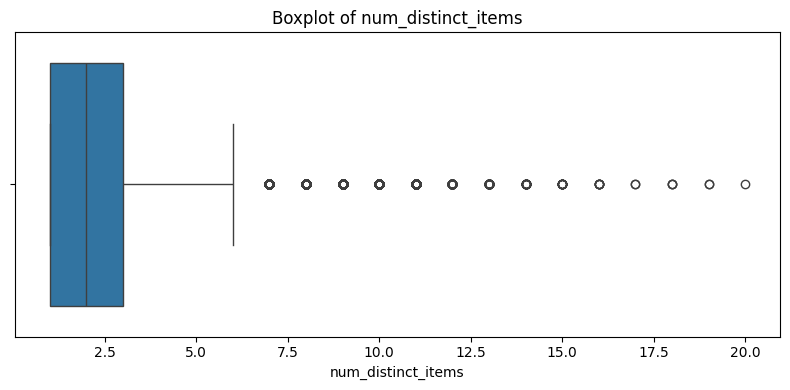

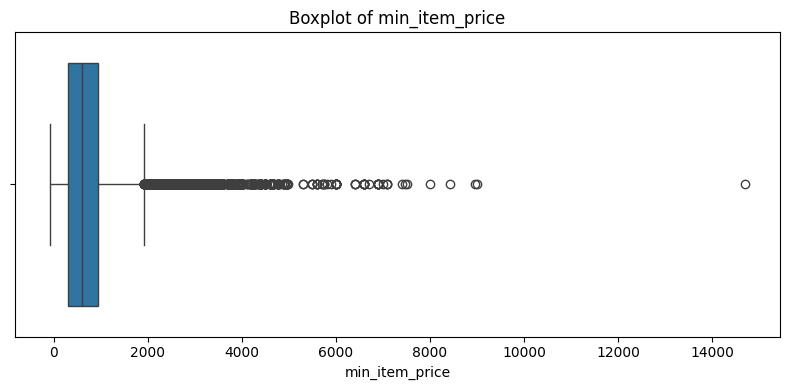

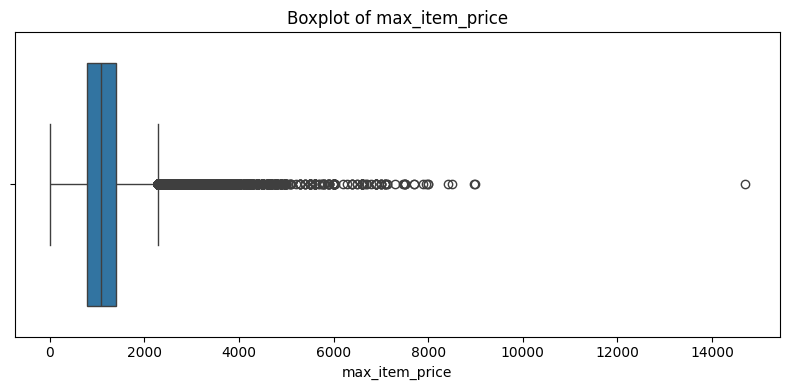

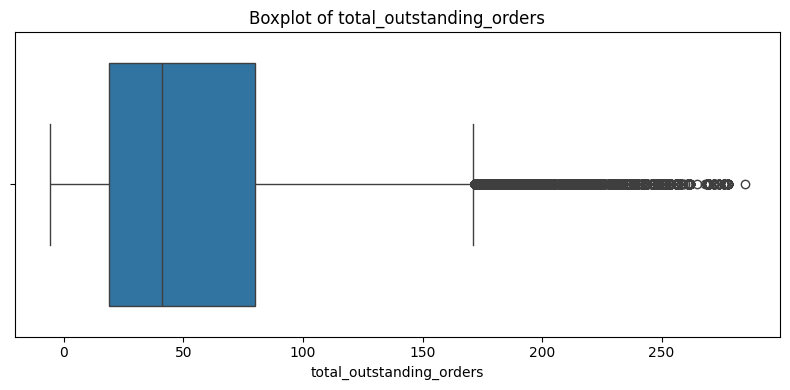

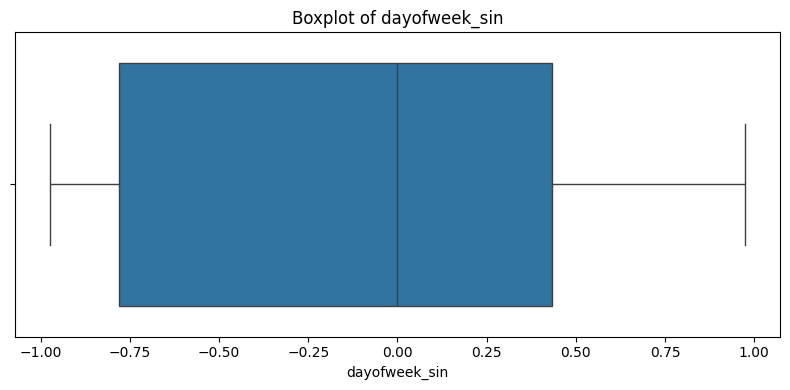

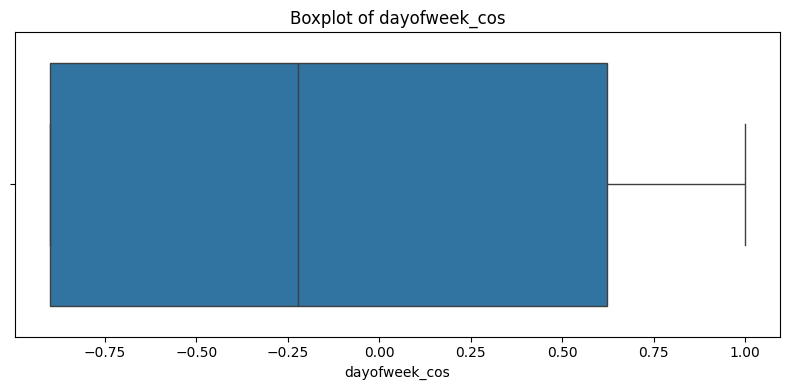

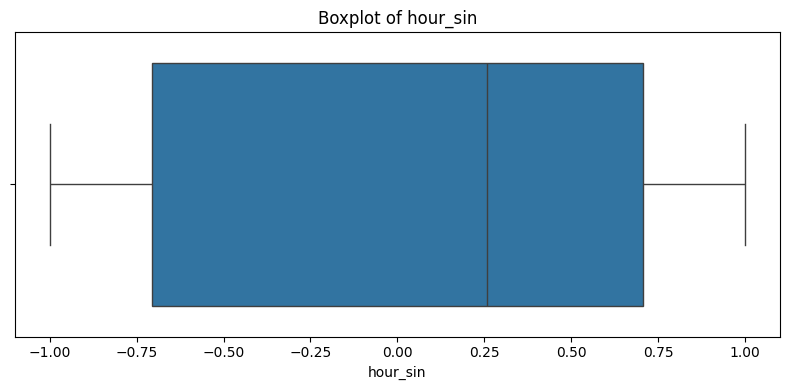

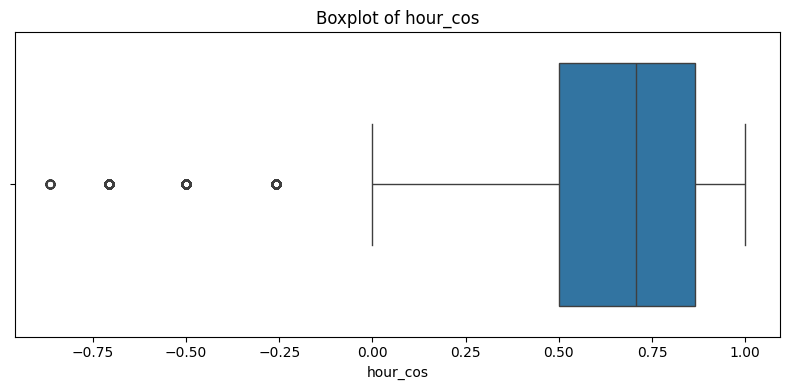

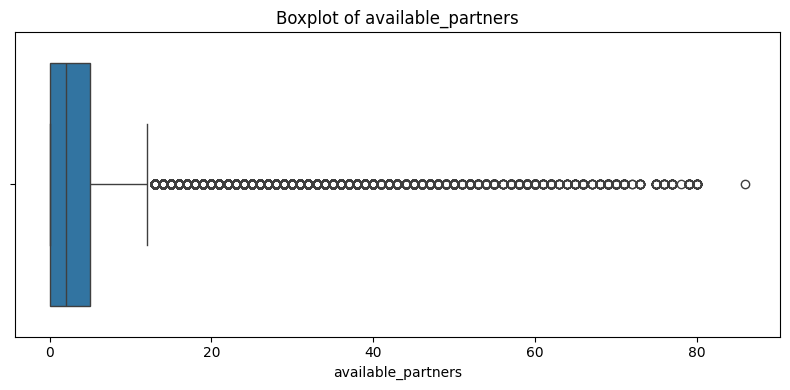

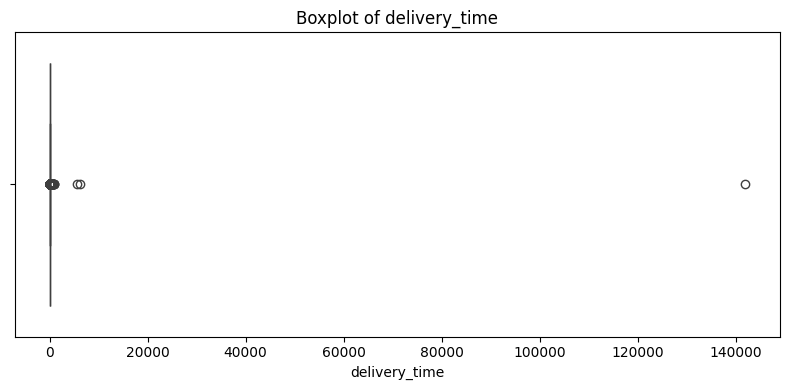

In [874]:
# Boxplots para checar a distribuição e possíveis outliers
outliers_check = pd.concat([train_x, train_y], axis=1)
numeric_features = outliers_check.select_dtypes(include=[np.number]).columns

for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=outliers_check[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

In [875]:
#remove outliers usando IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

In [876]:
columns_with_outliers = ["num_distinct_items", "delivery_time", "max_item_price", "available_partners", "total_outstanding_orders", "hour_cos", 'subtotal', 'total_items', 'min_item_price', 'max_item_price']

for col in columns_with_outliers:
    outliers_check = remove_outliers_iqr(outliers_check, col)

outliers_check.shape

(105763, 100)

In [877]:
train_x = outliers_check.drop(columns=["delivery_time"])
train_y = outliers_check["delivery_time"]

In [878]:
# Separando as colunas categóricas
cat_cols = train_x.select_dtypes(include=["bool", "category"]).columns

encoded_train_x = train_x[cat_cols]
encoded_test_x = test_x[cat_cols]

train_x = train_x.drop(columns=cat_cols)
test_x = test_x.drop(columns=cat_cols)

In [879]:
# Normalizando os dados
train_x_normalized = (train_x - train_x.mean(axis=0)) / train_x.std(axis=0)
test_x_normalized = (test_x - train_x.mean(axis=0)) / train_x.std(axis=0)

train_x_normalized = pd.concat([train_x_normalized, encoded_train_x.astype(int)], axis=1)
test_x_normalized = pd.concat([test_x_normalized, encoded_test_x.astype(int)], axis=1)

# Verificando as médias e desvios padrão dos dados normalizados para garantir que estão próximos de 0 e 1, respectivamente
print(f"Mean of train: {train_x_normalized.mean(axis=0)}")
print(f"Std of train: {train_x_normalized.std(axis=0)}")

print(f"Mean of test: {test_x_normalized.mean(axis=0)}")
print(f"Std of test: {test_x_normalized.std(axis=0)}")

Mean of train: total_items                         -1.148821e-16
subtotal                             1.770932e-16
num_distinct_items                   1.019831e-16
min_item_price                       1.222722e-16
max_item_price                       2.632212e-16
                                         ...     
store_primary_category_thai          3.771640e-02
store_primary_category_turkish       1.200798e-03
store_primary_category_vegan         1.777559e-03
store_primary_category_vegetarian    4.557359e-03
store_primary_category_vietnamese    3.366016e-02
Length: 99, dtype: float64
Std of train: total_items                          1.000000
subtotal                             1.000000
num_distinct_items                   1.000000
min_item_price                       1.000000
max_item_price                       1.000000
                                       ...   
store_primary_category_thai          0.190510
store_primary_category_turkish       0.034632
store_primary_category_veg

In [880]:
# Criando tensores do PyTorch
train_x_tensor = torch.tensor(train_x_normalized.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32).unsqueeze(1)
test_x_tensor = torch.tensor(test_x_normalized.values, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y.values, dtype=torch.float32).unsqueeze(1)

In [881]:
# Criando o modelo de regressão linear
class LinearRegressionModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [882]:
# Definindo o número de features, a função de perda e o otimizador
in_features = train_x_tensor.shape[1]
out_features = 1

model = LinearRegressionModel(in_features, out_features)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [883]:
epochs = 500
# Treinamento do modelo
for epoch in range(epochs):

    outputs = model(train_x_tensor)  # Forward pass

    loss = criterion(outputs, train_y_tensor)  # Calcula a perda

    # Backward pass e otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    print(f'Epoch [{epoch+1}/{epochs}], Loss: {(np.sqrt(loss.item())):.4f}')

Epoch [1/500], Loss: 46.7623
Epoch [2/500], Loss: 34.4714
Epoch [3/500], Loss: 26.3251
Epoch [4/500], Loss: 21.1313
Epoch [5/500], Loss: 17.9863
Epoch [6/500], Loss: 16.1819
Epoch [7/500], Loss: 15.1906
Epoch [8/500], Loss: 14.6590
Epoch [9/500], Loss: 14.3746
Epoch [10/500], Loss: 14.2191
Epoch [11/500], Loss: 14.1299
Epoch [12/500], Loss: 14.0749
Epoch [13/500], Loss: 14.0375
Epoch [14/500], Loss: 14.0096
Epoch [15/500], Loss: 13.9870
Epoch [16/500], Loss: 13.9674
Epoch [17/500], Loss: 13.9498
Epoch [18/500], Loss: 13.9336
Epoch [19/500], Loss: 13.9185
Epoch [20/500], Loss: 13.9044
Epoch [21/500], Loss: 13.8910
Epoch [22/500], Loss: 13.8784
Epoch [23/500], Loss: 13.8664
Epoch [24/500], Loss: 13.8551
Epoch [25/500], Loss: 13.8443
Epoch [26/500], Loss: 13.8341
Epoch [27/500], Loss: 13.8244
Epoch [28/500], Loss: 13.8152
Epoch [29/500], Loss: 13.8065
Epoch [30/500], Loss: 13.7982
Epoch [31/500], Loss: 13.7903
Epoch [32/500], Loss: 13.7828
Epoch [33/500], Loss: 13.7757
Epoch [34/500], Los

In [884]:
# Avaliação do modelo
model.eval()

with torch.no_grad():
    train_pred = model(train_x_tensor).cpu().numpy().flatten()
    test_pred = model(test_x_tensor).cpu().numpy().flatten()

train_true = train_y_tensor.cpu().numpy().flatten()
test_true = test_y_tensor.cpu().numpy().flatten()

# Métricas - treino
train_mse = mean_squared_error(train_true, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_true, train_pred)
train_r2 = r2_score(train_true, train_pred)

# Métricas - teste
test_mse = mean_squared_error(test_true, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_true, test_pred)
test_r2 = r2_score(test_true, test_pred)

print("=== Treino ===")
print(f"MSE : {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f} min")
print(f"MAE : {train_mae:.4f} min")
print(f"R²  : {train_r2:.4f}")

print("\n=== Teste ===")
print(f"MSE : {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f} min")
print(f"MAE : {test_mae:.4f} min")
print(f"R²  : {test_r2:.4f}")

=== Treino ===
MSE : 184.4993
RMSE: 13.5831 min
MAE : 10.8090 min
R²  : 0.1183

=== Teste ===
MSE : 323.9887
RMSE: 17.9997 min
MAE : 12.6450 min
R²  : 0.0743
